In [88]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from rasterio.plot import show, reshape_as_image
from pyproj import Transformer
from satsearch import Search

%matplotlib inline


In [89]:
# Cloud store
url = "https://earth-search.aws.element84.com/v0/"

# check for clouds in window
# Add alot of overhead. Set to None if not wanted
subset_cloud_tolerance = 2

bbox = [171.906166, -43.878840, 171.965904, -43.838489] ### CANTERBURY
images = []

In [90]:
def is_cloudy(scl, tolerance):
    image_size = scl.size
    unique, count = np.unique(scl, return_counts=True)
    counts = dict(zip(unique, count))

    # Total cloud types
    cloud_med_probability = counts.get(8, 0)
    cloud_high_probability = counts.get(9, 0)
    thin_cirrus = counts.get(10, 0)
    total_cloud_cover = cloud_med_probability + cloud_high_probability + thin_cirrus  
    
    # percent subscene cloud cover
    percent_cloud_cover = 100 * float(total_cloud_cover) / float(image_size)
    print(f"/tcloud cover {percent_cloud_cover}%")
    if percent_cloud_cover > tolerance:
        return True
    return False

In [91]:
transform_window = None
def range_request(geotiff_href, bbox):

    
    
    
    with rasterio.open(geotiff_href) as src:
        coord_transformer = Transformer.from_crs("epsg:4326", src.crs)
        # calculate pixels to be streamed in cog
        coord_upper_left = coord_transformer.transform(bbox[3], bbox[0])
        coord_lower_right = coord_transformer.transform(bbox[1], bbox[2])
        pixel_upper_left = src.index(coord_upper_left[0], coord_upper_left[1])
        pixel_lower_right = src.index(coord_lower_right[0], coord_lower_right[1])
         
        
        for pixel in pixel_upper_left + pixel_lower_right:
            # If the pixel value is below 0, that means that
            # the bounds are not inside of our available dataset.
            if pixel < 0:
                print("Provided geometry extends available datafile.")
                print("Provide a smaller area of interest to get a result.")
                exit()
                
        #make http range request only for bytes in window
        window = rasterio.windows.Window.from_slices(  # need to move and store this once
            (pixel_upper_left[0], pixel_lower_right[0]),
            (pixel_upper_left[1], pixel_lower_right[1]),
        )

        transform_window = rasterio.windows.transform(window,src.transform) # need to store this once
        
        bands = 1
        if "TCI" in geotiff_href:
            bands = [1, 2, 3]

        subset = src.read(bands, window=window)
        return(subset, transform_window)

In [92]:
# Search Stac cat for images
bbox_search = Search(
    bbox=bbox,
    datetime="2020-12-01/2021-12-20",
    query={
        "eo:cloud_cover": {"lt": 80}
    },  
    collections=["sentinel-s2-l2a-cogs"],
    url=url,
)

In [93]:
# pull out RGB (TCI) red && nir
images= []

items = bbox_search.items()
for item in items:
    
    # Refs to images
    red = item.asset("red")["href"]
    nir = item.asset("nir")["href"]
    rgb = item.asset("visual")["href"]
    scl = item.asset("SCL")["href"]
    date = item.date.strftime("%d/%m/%Y")
    
    # if subset_cloud_tolerance is set. check clouds in 
    # window before continuing 
    if subset_cloud_tolerance:
        print(f"Assessing Cloud Cover: {date}")
        scl_subset, transform_window = range_request(scl, bbox)
        if is_cloudy(scl_subset, subset_cloud_tolerance):
            print(f"clouds in subset-scene: {date}")
            continue  

    # Streamed pixels within Bbox
    red_subset, transform_window = range_request(red, bbox)
    nir_subset, transform_window = range_request(nir, bbox)
    rgb_subset, transform_window = range_request(rgb, bbox)
    
    
    # Calcualte NDVI
    ndvi_subset = (nir_subset.astype(float) - red_subset.astype(float)) / (
        nir_subset + red_subset
    )
    
    
    # Store of images in date range and bbox
    images.append(
        {"date": date, "rgb": rgb_subset, "ndvi": ndvi_subset,'transform_window': transform_window}
    )


Assessing Cloud Cover: 29/11/2021
/tcloud cover 100.0%
clouds in subset-scene: 29/11/2021
Assessing Cloud Cover: 14/11/2021
/tcloud cover 10.713953790962657%
clouds in subset-scene: 14/11/2021
Assessing Cloud Cover: 04/11/2021
/tcloud cover 0.011152623654714772%
Assessing Cloud Cover: 30/10/2021
/tcloud cover 0.05948065949181212%
Assessing Cloud Cover: 20/10/2021
/tcloud cover 39.66058848677485%
clouds in subset-scene: 20/10/2021
Assessing Cloud Cover: 30/09/2021
/tcloud cover 0.020446476700310415%
Assessing Cloud Cover: 20/09/2021
/tcloud cover 100.0%
clouds in subset-scene: 20/09/2021
Assessing Cloud Cover: 15/09/2021
/tcloud cover 70.71878659454637%
clouds in subset-scene: 15/09/2021
Assessing Cloud Cover: 10/09/2021
/tcloud cover 0.009293853045595643%
Assessing Cloud Cover: 31/08/2021
/tcloud cover 0.005576311827357386%
Assessing Cloud Cover: 06/08/2021
/tcloud cover 56.16647149575271%
clouds in subset-scene: 06/08/2021
Assessing Cloud Cover: 01/08/2021
/tcloud cover 99.78810015056

In [94]:
images.reverse()


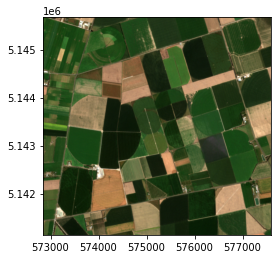

<AxesSubplot:>

In [96]:
show(images[0]['rgb'], transform=images[0]['transform_window'] )

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex="col", sharey="row")

ndvi_axes = show(images[0]['ndvi'],
                  ax=ax1, 
                  transform=images[0]['transform_window'],
                  cmap="RdYlGn", 
                  vmin=-1, 
                  vmax=1, 
                 )
ndvi_axes.ticklabel_format(style ='plain') # use full y-coord text

rgb_axes = show(images[0]['rgb'],ax=ax2, transform=images[0]['transform_window'])

SyntaxError: invalid syntax (<ipython-input-104-5641fd05090c>, line 5)

In [98]:
# add titles
title = ndvi_axes.text(
    0.5,
    1.100,
    "",
    bbox={"facecolor": "white", "alpha": 0.5, "pad": 5},
    transform=ax1.transAxes,
    ha="center",
)

In [99]:
#get the AxesImage
ndvi_axesimage = ndvi_axes.get_images()[0]
rgb_axesimage = rgb_axes.get_images()[0]

In [100]:
fig.colorbar(ndvi_axesimage, ax=ndvi_axes, shrink=0.53)
fig.colorbar(rgb_axesimage, ax=rgb_axes).remove()



In [101]:
def updatefig(i):

    ndvi_axesimage.set_array(images[i]["ndvi"])
    rgb_axesimage.set_array(reshape_as_image(images[i]["rgb"]))
    anim_title = title.set_text(images[i]["date"])
    return ndvi_axesimage, rgb_axesimage

In [102]:
ani = animation.FuncAnimation(
    fig, updatefig, frames=range(1, len(images)), interval=2000, blit=True
)

In [103]:
ani.save(
    filename="/home/splanzer/Downloads/animation_sbs_TEST_rasterio2.gif",
    writer="imagemagick",
    fps=0.5,
    savefig_kwargs=dict(facecolor="#EAEAF2"),
)